#DDoS Attack Detection and Analysis:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import os, sys # For accessing Python Modules in the System Path (for accessing the Statistical Measures modules)
# See: https://stackoverflow.com/a/39311677
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import pandas as pd # For DataFrames, Series, and reading csv data in.
import seaborn as sns # Graphing, built ontop of MatPlot for ease-of-use and nicer diagrams.
import matplotlib.pyplot as plt # MatPlotLib for graphing data visually. Seaborn more likely to be used.
import numpy as np # For manipulating arrays and changing data into correct formats for certain libraries
import sklearn # For Machine Learning algorithms
from sklearn.metrics import confusion_matrix

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Books/Tuesday-WorkingHours.pcap_ISCX.csv.zip')

In [ ]:
df.shape

(445909, 79)

#Importing Libraries:

In [ ]:
from sklearn.preprocessing import StandardScaler # For scaling to unit scale, before PCA application
from sklearn.model_selection import StratifiedKFold # For optimal train_test splitting, for model input data
from sklearn.model_selection import train_test_split # For basic dataset splitting
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors ML classifier (default n. of neighbors = 5)
from sklearn.metrics import confusion_matrix# For plotting confusion matrices
from sklearn.metrics import accuracy_score # For getting the accuracy of a model's predictions
from sklearn.metrics import classification_report # Various metrics for model performance
from sklearn.linear_model import LogisticRegression

#Functions:

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [ ]:
def get_shuffled_stratifiedKFold_train_test_split(X, y):
    # Shuffle to True, to get different shuffles each time. Permutations being varied is the goal here.
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    # For loop to get index for training and test data, using StratifiedKFold (3 splits)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    # After for loop ends, all training and test data has been retrieved thus can return it.
    return X_train, X_test, y_train, y_test

In [ ]:
print("Datatype of Dataframe i.e. Pandas Dataframe: ", type(df))
print("Datatype of Column i.e. Pandas Series: ", type(df.iloc[:, 1]))
df.head()

Datatype of Dataframe i.e. Pandas Dataframe:  <class 'pandas.core.frame.DataFrame'>
Datatype of Column i.e. Pandas Series:  <class 'pandas.core.series.Series'>


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323251,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538462,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


#Data Cleaning:

In [ ]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323251,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538462,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

In [ ]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned) # see methods at top of notebook
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323251,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538462,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445904,53,155,2,2,88,120,44,44,44.000000,0.000000,60,60,60.0,0.000000,1341935.484,25806.451610,51.666667,83.428612,148,3,3,3.000000,0.000000,3,3,4,4.000000,0.000000,4,4,0,0,0,0,64,64,12903.225810,12903.225810,44,60,50.400000,8.763561,76.800000,0,0,0,0,0,0,0,0,1,63.000000,44.000000,60.0,64,0,0,0,0,0,0,2,88,2,120,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
445905,59317,110,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0

In [ ]:
df_cleaned = df_cleaned.reset_index()
# Removing un-needed index column added by reset_index method
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes/s,flow_packets/s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets/s,bwd_packets/s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down/up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,fwd_avg_bytes/bulk,fwd_avg_packets/bulk,fwd_avg_bulk_rate,bwd_avg_bytes/bulk,bwd_avg_packets/bulk,bwd_avg_bulk_rate,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323251,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538462,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445640,53,155,2,2,88,120,44,44,44.000000,0.000000,60,60,60.0,0.000000,1341935.484,25806.451610,51.666667,83.428612,148,3,3,3.000000,0.000000,3,3,4,4.000000,0.000000,4,4,0,0,0,0,64,64,12903.225810,12903.225810,44,60,50.400000,8.763561,76.800000,0,0,0,0,0,0,0,0,1,63.000000,44.000000,60.0,64,0,0,0,0,0,0,2,88,2,120,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
445641,59317,110,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0

In [ ]:
df.columns.tolist()

In [ ]:
# Saving the label attribute before dropping it.
df_labels = df_cleaned['label']
# Shows all the possible labels/ classes a model can predict.
df_labels.unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator'], dtype=object)

In [ ]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

In [ ]:
df = df_cleaned .copy()

#Feature Reduction:


In [ ]:
# drop duplicate rows
df =  df.drop_duplicates(keep="first")
df.reset_index(drop=True,inplace=True)


In [ ]:
#feature reduction 
#dropping very high correlated features 
corr_matrix = df.corr().abs()
corr_matrix.shape

(78, 78)

In [ ]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Select upper triangle of correlation matrix


In [ ]:
# Find features with correlation greater than 0.50
to_drop = [column for column in upper.columns if any(upper[column] > 0.50)]

# Drop features 
df =  df.drop(to_drop, axis=1)
df.shape

(421626, 32)

#Correlation:

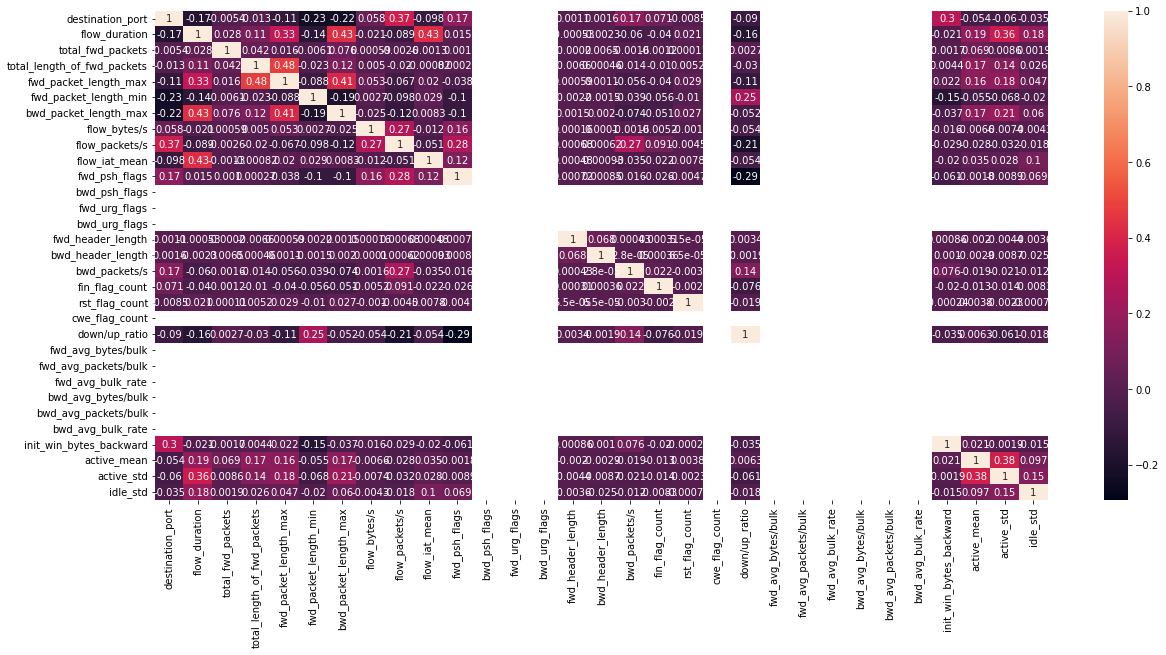

In [ ]:
#Coralation plot
corr = df.corr()
plt.subplots(figsize=(20,9))
sns.heatmap(corr, annot=True)

In [ ]:
df.info()

In [ ]:
df.nunique()

In [ ]:
df.info()

#Label Encoding:

In [ ]:
df['label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator'], dtype=object)

In [ ]:
label_map = {'label' : {'BENIGN' : 0, 'FTP-Patator' : 1 , 'SSH-Patator' : 2} }

In [ ]:
df = df.replace(label_map)

In [ ]:
print("Before Labelencoding: ", df_labels.unique())
print("After Labelencoding: ", df['label'].unique())

Before Labelencoding:  ['BENIGN' 'FTP-Patator' 'SSH-Patator']
After Labelencoding:  [0 1 2]


#Splitting Data into Train and Test:

In [ ]:
# Separating the label so that the answers aren't provided to the model, in training.
X = df.drop(['label'], axis = 1)
y = df['label']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)


#Normalization:

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Target Analysis:

In [ ]:
y.value_counts()

0    412476
1      5931
2      3219
Name: label, dtype: int64

In [ ]:
y[y==0].shape[0] / y.shape[0]# no of rows contains 0 /total no of rows

0.9782983022868609

In [ ]:
y[y==1].shape[0] / y.shape[0]

0.01406696930454953

In [ ]:
y[y==2].shape[0] / y.shape[0]

0.0076347284085896035

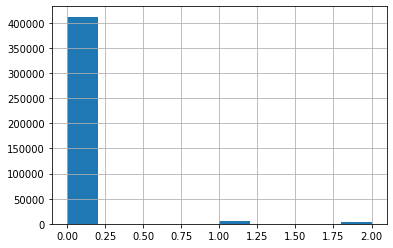

In [ ]:
y.hist()

#Undersampling  
for making data balancing:

In [ ]:
X.shape,y.shape

((421626, 31), (421626,))

In [ ]:
X_0 = X.loc[y==0]
X_1 = X.loc[y==1]
X_2 = X.loc[y==2]

In [ ]:
X_0.shape,X_1.shape,X_2.shape

((412476, 31), (5931, 31), (3219, 31))

In [ ]:
X_0 = X_0.sample(X_1.shape[0],random_state=7)

In [ ]:
X_0.shape,X_1.shape,X_2.shape

((5931, 31), (5931, 31), (3219, 31))

In [ ]:
X_bal = pd.concat([X_0,X_1,X_2],axis=0)

In [ ]:
X_bal.shape

(15081, 31)

In [ ]:
Y_bal = y.loc[X_bal.index]

In [ ]:
Y_bal.shape

(15081,)

In [ ]:
Y_bal.value_counts()

1    5931
0    5931
2    3219
Name: label, dtype: int64

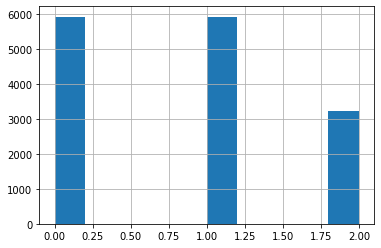

In [ ]:
Y_bal.hist()

In [ ]:
 X_train, X_test,y_train, y_test=get_shuffled_stratifiedKFold_train_test_split(X_bal, Y_bal)

In [ ]:
   
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  10054
y_train length:  10054
X_test length:  5027
y_test length:  5027


#KNN Algorithm:

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                                    algorithm='auto', leaf_size=30,
                                    p=2, metric='minkowski',
                                    metric_params=None, n_jobs=None)

In [ ]:
knn_model.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
preds = knn_model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, preds)) #to evaluate performance of classificaion models.compares actual value with predicted value
print(classification_report(y_test, preds))

[[1949   12   16]
 [  12 1962    3]
 [  22    7 1044]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1977
           1       0.99      0.99      0.99      1977
           2       0.98      0.97      0.98      1073

    accuracy                           0.99      5027
   macro avg       0.99      0.98      0.98      5027
weighted avg       0.99      0.99      0.99      5027



#Model Building:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [ ]:
models = [LogisticRegression(multi_class='multinomial', solver='lbfgs'),
          KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(),
          AdaBoostClassifier(n_estimators=100, random_state=7),GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=7)
          ,RandomForestClassifier(random_state=7)]
classifiers = ["lgr","KNN","DecisionTree","adb","gbc","rfc"]
scores = []

In [ ]:
for model in models:
    print('============================== {} Model Evaluation =============================='.format(model))
    model.fit(X_train,y_train)
    Y_pred = model.predict(X_test)
    score = accuracy_score(y_test, Y_pred)*100
    scores.append(score)
    print("Accuracy of  model is: ", score)
    conf_matrix = confusion_matrix(y_test,Y_pred)
    report = classification_report(y_test,Y_pred)
    print("Confusion Matrix:\n",conf_matrix)
    print("Report:\n",report)
    

============================== LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) Model Evaluation ==============================


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of  model is:  82.23592599960214
Confusion Matrix:
 [[1861  106   10]
 [ 688 1289    0]
 [  76   13  984]]
Report:
               precision    recall  f1-score   support

           0       0.71      0.94      0.81      1977
           1       0.92      0.65      0.76      1977
           2       0.99      0.92      0.95      1073

    accuracy                           0.82      5027
   macro avg       0.87      0.84      0.84      5027
weighted avg       0.85      0.82      0.82      5027

============================== KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform') Model Evaluation ==============================
Accuracy of  model is:  98.72687487567137
Confusion Matrix:
 [[1945   12   20]
 [   7 1965    5]
 [  16    4 1053]]
Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of  model is:  99.98010741993237
Confusion Matrix:
 [[1976    1    0]
 [   0 1977    0]
 [   0    0 1073]]
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1977
           1       1.00      1.00      1.00      1977
           2       1.00      1.00      1.00      1073

    accuracy                           1.00      5027
   macro avg       1.00      1.00      1.00      5027
weighted avg       1.00      1.00      1.00      5027

============================== RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_

#Ensembling:

Voting is an ensemble machine learning algorithm. .. A voting ensemble involves summing the predictions made by classification models or averaging the predictions made by regression models.


In [ ]:
from sklearn.ensemble import VotingClassifier##
clf1 = DecisionTreeClassifier(criterion='gini', max_depth=33, random_state=20, max_features=7, splitter='random')
clf2 = RandomForestClassifier(criterion='gini', max_depth=40, random_state=20)
#clf3 =  AdaBoostClassifier(n_estimators=100, random_state=7)
#clf4 = KNeighborsClassifier(n_neighbors=3)
#clf5 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=7)
votingC = VotingClassifier(estimators=[('dc',clf1), ('rf', clf2)],voting='hard', weights=[2,2],flatten_transform=True)
votingC.fit(X_train,y_train)

VotingClassifier(estimators=[('dc',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=33,
                                                     max_features=7,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=20,
          

In [ ]:
Y_pred = votingC.predict(X_test)
score = accuracy_score(y_test, Y_pred)*100
scores.append(score)
print("Accuracy of  model is: ", score)
conf_matrix = confusion_matrix(y_test,Y_pred)
report = classification_report(y_test,Y_pred)
print("Confusion Matrix:\n",conf_matrix)
print("Report:\n",report)
print("\n==============***===============")
print('============================== {} Model Evaluation =============================='.format(votingC))
    
    

Accuracy of  model is:  99.88064451959418
Confusion Matrix:
 [[1976    1    0]
 [   2 1975    0]
 [   3    0 1070]]
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1977
           1       1.00      1.00      1.00      1977
           2       1.00      1.00      1.00      1073

    accuracy                           1.00      5027
   macro avg       1.00      1.00      1.00      5027
weighted avg       1.00      1.00      1.00      5027


==============***===============
============================== VotingClassifier(estimators=[('dc',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=33,
                                                     max_features=7,
                                              

In [ ]:
from sklearn.ensemble import VotingClassifier

clf1 = DecisionTreeClassifier(criterion='gini', max_depth=33, random_state=20, max_features=7, splitter='random')
#clf2 = RandomForestClassifier(criterion='gini', max_depth=40, random_state=20)
#clf3 =  AdaBoostClassifier(n_estimators=100, random_state=7)
clf4 = KNeighborsClassifier(n_neighbors=3)
#clf5 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=7)
votingC = VotingClassifier(estimators=[('dc',clf1),('knn',clf4) ],voting='hard', weights=[2,2],flatten_transform=True)
votingC.fit(X_train,y_train)

VotingClassifier(estimators=[('dc',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=33,
                                                     max_features=7,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=20,
          

In [ ]:

print('============================== {} Model Evaluation =============================='.format(votingC))
Y_pred = votingC.predict(X_test)
score = accuracy_score(y_test, Y_pred)*100
scores.append(score)
print("Accuracy of  model is: ", score)
conf_matrix = confusion_matrix(y_test,Y_pred)
report = classification_report(y_test,Y_pred)
print("Confusion Matrix:\n",conf_matrix)
print("Report:\n",report)


============================== VotingClassifier(estimators=[('dc',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=33,
                                                     max_features=7,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                 